In [69]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy.stats import linregress
import math
import seaborn as sns

In [57]:
PEARSONBOUND = 0.5

In [58]:
basicFileName="basic_data.csv"
basicDF=pd.read_csv('../data/'+basicFileName)
basicDF.drop_duplicates(inplace=True)
basicDF['Symbol'].to_csv('../data/'+'ETFs.csv',index=False)


In [59]:
def firstSelect(df):
    
    #Inception记录股票上市时间
    firstDF=df[['Symbol','Fund Name','Assets','Category','Index','Inception','Volume']]
    print(len(firstDF))
    firstDF.dropna(inplace=True,subset=['Category'])
    firstDF.dropna(inplace=True,subset=['Index'])
    firstDF.dropna(inplace=True,subset=['Assets'])
    print(len(firstDF))

    category_counts=firstDF['Category'].value_counts()
    firstDF=firstDF[firstDF['Category'].isin(category_counts[category_counts>5].index)]
    firstDF = firstDF.loc[firstDF.groupby('Index')['Assets'].idxmax()]

    # 重置索引（可选）
    firstDF = firstDF.reset_index(drop=True)

    print(len(firstDF))

    firstDF[['Index','Symbol']].to_csv("./111.csv")
    return firstDF
    

firstDF=firstSelect(basicDF)

3963
2136
1763


/tmp/ipykernel_3158792/2128863428.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  firstDF.dropna(inplace=True,subset=['Category'])
/tmp/ipykernel_3158792/2128863428.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  firstDF.dropna(inplace=True,subset=['Index'])
/tmp/ipykernel_3158792/2128863428.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  firstDF.dropna(inplace=True,subset=['Assets'])


In [60]:
#计算每类股票的资产总和
def category_assets(df):
    require_colums= ["Category","Assets"]
    for col in require_colums:
        if col not in firstDF.columns:
            print("Error: Missing column "+col)
            return

    df["Assets"]=pd.to_numeric(df["Assets"],errors='coerce')
    categorys=df.groupby("Category")["Assets"].sum().reset_index()
    categorys=categorys.sort_values("Assets",ascending=False)
    
    print("\nNet Assets by Category:\n")
    
    
    categorys.to_csv("../data/category_assets.csv")
    return categorys

categorys=category_assets(firstDF)
categorys.to_csv("../data/categorys.csv")
print(categorys["Category"])
# print(categorys[categorys["Category"]=="Large Blend"])


Net Assets by Category:

38                Large Blend
39               Large Growth
40                Large Value
18        Foreign Large Blend
66                 Technology
               ...           
64        Tactical Allocation
53        Nontraditional Bond
60            Single Currency
67    Trading--Inverse Equity
14              Equity Hedged
Name: Category, Length: 73, dtype: object


In [61]:
#Setp3:删除流动性和资产小于 val 的基金



def filter_fund(df,categorys):
    #决定使用哪种方式保留ETF
    #0表示绝对数额，1表示百分比
    method=1
    
    
    
    filtered_df = df.copy()
    require_colums= ["Category","Assets","Volume"]
    for col in require_colums:
        if col not in firstDF.columns:
            print("Error: Missing column "+col)
            return

    totAssets=categorys["Assets"].sum()
    print("Total Assets: ",totAssets)
        
    cateVal={"-1":-1}
    for etf in df["Category"]:
        cateVal[etf]=categorys[categorys["Category"]==etf]["Assets"].values[0]
    
    df["calval"]=df["Category"].map(cateVal)
    
    # 保留Assets大于0.1%总资产的基金和大于5%该类资产的基金
    if(method==0):
        
        filtered_df = df[
            (df['Assets'] > 0.001 * totAssets) |
            (df['Assets'] > df['Category'].map(lambda ca: 0.05 * cateVal.get(ca, 0)))
        ]
    
    if(method==1):
        # 第一步：计算全局的 Assets 后 10% 阈值
        global_threshold = filtered_df['Assets'].quantile(0.10)

        # 第二步：对每个 Category 计算 Assets 后 25% 的阈值
        category_thresholds = filtered_df.groupby('Category')['Assets'].transform(lambda x: x.quantile(0.25))

        # 第三步：过滤掉满足任一条件的股票
        filtered_df = filtered_df[~((filtered_df['Assets'] <= category_thresholds) | (df['Assets'] <= global_threshold))]

    
    filtered_df = filtered_df[~filtered_df['Category'].str.contains('Leverage', na=False)]
    filtered_df.to_csv("../data/filter_fund.csv")
    
    filtered_df["Symbol"].to_csv("../data/ETF1s.csv",index=False)
    return filtered_df

secondDF=filter_fund(firstDF,categorys)
categorys=category_assets(firstDF)
print(len(secondDF))
secondDF["Symbol"].to_csv("./ETF2.csv",index=False)

Total Assets:  7760177616282.0

Net Assets by Category:

1258


In [62]:
# linear_regression(SPY,ETF)
# find alpha and beta and 皮尔逊相关系数

def linear_regression_time(basicDf1,basicDf2,st,et):
    st=pd.to_datetime(st).date()
    et=pd.to_datetime(et).date()
    
    # basicDf1["Date"]=pd.to_datetime(basicDf1["date"]).dt.date
    # basicDf2["Date"]=pd.to_datetime(basicDf2["date"]).dt.date
    basicDf1=basicDf1[(basicDf1["Date"]>=st) & (basicDf1["Date"]<=et)]
    basicDf2=basicDf2[(basicDf2["Date"]>=st) & (basicDf2["Date"]<=et)]
    # common_dates=set(basicDf1['Date']).intersection(set(basicDf2['Date']))
    # common_dates=sorted(list(common_dates))
    
    # df1=basicDf1[basicDf1['Date'].isin(common_dates)]
    # df2=basicDf2[basicDf2['Date'].isin(common_dates)]
    if(len(basicDf1)<=5 or len(basicDf2)<=5):
        return np.nan,np.nan,False
    
    basicDf1.reset_index(drop=True,inplace=True)
    basicDf2.reset_index(drop=True,inplace=True)
    df1=basicDf1[['Date','close']]
    df2=basicDf2[['Date','close']]
    
    df=pd.merge(df1[['Date','close']],df2[['Date','close']],on='Date',suffixes=('_1','_2'))
    
    
    df['return1']=df1['close'].pct_change()
    df['return2']=df2['close'].pct_change()
    
    
    df=df.dropna()
    x = sm.add_constant(df['return1'])
    y = df['return2']

    model = sm.OLS(y, x).fit()
    
    alpha = model.params['const']
    beta = model.params['return1']
    
    correlation=np.corrcoef(df['return1'],df['return2'])[0,1]
    
    
    # print("Alpha:", alpha)
    # print("Beta:", beta)
    # # 绘制 SPY 和 ETF 收益率的散点图和回归线
    # plt.figure(figsize=(10, 6))
    # plt.scatter(df['return1'], df['return2'], label='Data Points', alpha=0.6)
    # plt.plot(df['return1'], alpha + beta * df['return1'], color='red', label='Regression Line')

    # # 添加图表标题和标签
    # plt.title('ETF Returns vs SPY Returns (Alpha and Beta)', fontsize=16)
    # plt.xlabel('SPY Returns', fontsize=12)
    # plt.ylabel('ETF Returns', fontsize=12)
    # plt.legend()
    # plt.grid(True)
    # plt.show()
    return alpha,beta,(abs(correlation)>PEARSONBOUND)



def linear_regression(basicDf1,basicDf2):
    basicDf1["Date"]=pd.to_datetime(basicDf1["date"]).dt.date
    basicDf2["Date"]=pd.to_datetime(basicDf2["date"]).dt.date
    common_dates=set(basicDf1['Date']).intersection(set(basicDf2['Date']))
    common_dates=sorted(list(common_dates))
    
    df1=basicDf1[basicDf1['Date'].isin(common_dates)]
    df2=basicDf2[basicDf2['Date'].isin(common_dates)]
    
    
    df1.reset_index(drop=True,inplace=True)
    df2.reset_index(drop=True,inplace=True)
    
    
    alphas=[]
    betas=[]
    correlations=[]
    for year in range(2010,2026):
        st=str(year)+'-01-01'
        et=str(year)+'-12-31'
        a,b,c=linear_regression_time(df1,df2,st,et)
        alphas.append(a)
        betas.append(b)
        correlations.append(c)
    
    alphaBeta=pd.DataFrame({'Year':range(2010,2026),'Alpha':alphas,'Beta':betas,'Correlation':correlations})
    
    # print("Alpha:", alpha)
    # print("Beta:", beta)
    # # 绘制 SPY 和 ETF 收益率的散点图和回归线
    # plt.figure(figsize=(10, 6))
    # plt.scatter(df['return1'], df['return2'], label='Data Points', alpha=0.6)
    # plt.plot(df['return1'], alpha + beta * df['return1'], color='red', label='Regression Line')

    # # 添加图表标题和标签
    # plt.title('ETF Returns vs SPY Returns (Alpha and Beta)', fontsize=16)
    # plt.xlabel('SPY Returns', fontsize=12)
    # plt.ylabel('ETF Returns', fontsize=12)
    # plt.legend()
    # plt.grid(True)
    # plt.show()
    return alphaBeta



dfSPY=pd.read_csv("../data/daily_data/SPY_daily.csv")
dfQQQ=pd.read_csv("../data/daily_data/QQQ_daily.csv")
# a,b,c=linear_regression(dfSPY,dfVOO)

In [83]:
def calculate_alpha_beta_val(alphaBeta):
    namda=0.98 #权重
    minAlpha=114.514
    minBeta=114.514
    AlphaScore=0.0
    BetaScore=0.0
    totyear=0
    for year in range(2010,2026):
        i=year-2010
        if(np.isnan(alphaBeta.loc[i,'Alpha'])):
            continue
        
        # AlphaScore+=math.pow(namda,2025-year)*(alphaBeta.loc[i,'Alpha'])
        # BetaScore+=math.pow(namda,2025-year)*(alphaBeta.loc[i,'Beta'])
        
        AlphaScore+=alphaBeta.loc[i,'Alpha']
        BetaScore+=alphaBeta.loc[i,'Beta']
        minAlpha=min(minAlpha,alphaBeta.loc[i,'Alpha'])
        minBeta=min(minBeta,alphaBeta.loc[i,'Beta'])
        totyear+=1
    
    if totyear==0:
        return np.nan,np.nan,np.nan,np.nan
    AlphaScore=AlphaScore/totyear
    BetaScore=BetaScore/totyear
    return AlphaScore,minAlpha,BetaScore,minBeta

In [84]:
def chooseGoodAlpha(df):
    goodETFs=[]
    SPYETF=pd.read_csv("../data/daily_data/SPY_daily.csv")
    for etf in df["Symbol"]:
        try :
            dfETF=pd.read_csv("../data/daily_data/"+etf+"_daily.csv")
        except Exception as e:
            print("Error: ",etf)
            print(e)
            continue
        if len(dfETF)<10:
            print("Empty: ",etf)
            continue
        # print(etf)
        # print(len(dfETF))
        # print(SPYETF.head())
        # print(dfETF.head())
        alphaBeta=linear_regression(SPYETF,dfETF)
        
        AlphaScore,minAlpha,BetaScore,minBeta=calculate_alpha_beta_val(alphaBeta)
        goodETFs.append([etf,AlphaScore,minAlpha,BetaScore,minBeta])
        goodETFs.append(['short '+etf,-AlphaScore,-minAlpha,-BetaScore,-minBeta])
        
        
    
    return goodETFs

alphaBeta=chooseGoodAlpha(secondDF)

[['USL', -7.065664205614699e-05, -0.0018355992934518364, 0.5937958286355492, -0.2272711447286998], ['short USL', 7.065664205614699e-05, 0.0018355992934518364, -0.5937958286355492, 0.2272711447286998], ['AIEQ', -0.00018580001420444374, -0.0006060937571774732, 1.1193965843585951, 0.8820995222131944], ['short AIEQ', 0.00018580001420444374, 0.0006060937571774732, -1.1193965843585951, -0.8820995222131944], ['IZRL', -0.00018076752852329793, -0.0013264409605551872, 1.0420754144025455, 0.7511681157539731], ['short IZRL', 0.00018076752852329793, 0.0013264409605551872, -1.0420754144025455, -0.7511681157539731], ['AUSF', 0.00022974025106790852, -0.0005770129054270608, 0.6954671482009808, 0.36516008429366664], ['short AUSF', -0.00022974025106790852, 0.0005770129054270608, -0.6954671482009808, -0.36516008429366664], ['ONOF', -7.768520844324816e-05, -0.00032229283249286957, 0.8243957376673938, 0.44284807272498006], ['short ONOF', 7.768520844324816e-05, 0.00032229283249286957, -0.8243957376673938, -0

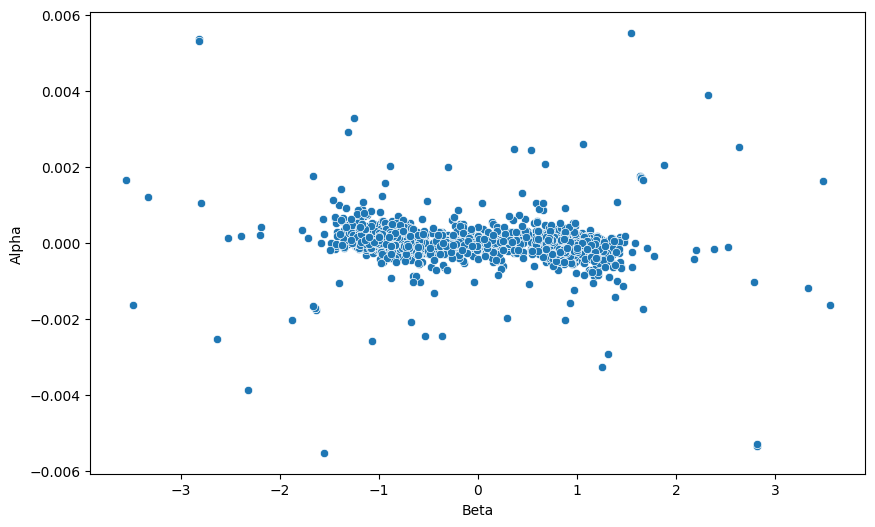

In [85]:
print(alphaBeta)
def drawAlphaBeta(alphaBeta):
    alphaBetaDF=pd.DataFrame(alphaBeta,columns=['ETF','Alpha','minAlpha','Beta','minBeta'])
    alphaBetaDF.to_csv("../data/alphaBeta.csv")
    plt.figure(figsize=(10, 6))
    # sns.scatterplot(x='',y='Alpha',data=alphaBetaDF)
    sns.scatterplot(x='Beta',y='Alpha',data=alphaBetaDF)
drawAlphaBeta(alphaBeta)

In [103]:
def findObnormal(alphaBeta):
    alphaBetaDF=pd.DataFrame(alphaBeta,columns=['ETF','Alpha','minAlpha','Beta','minBeta'])
    goodAlpha=[]
    goodBeta=[]
    length=len(alphaBetaDF)
    for i in range(length):
        # print(etf)
        # continue
        etf=alphaBetaDF.loc[i]
        if(etf['Alpha']>0.004):
            goodAlpha.append(etf)
        if(abs(etf['Beta'])>2) & (etf['Alpha']>0):
            goodBeta.append(etf)
    # print(goodAlpha)
    # print(goodBeta)
    return goodAlpha,goodBeta

goodAlpha,goodBeta=findObnormal(alphaBeta)
print(pd.DataFrame(goodAlpha))
print(pd.DataFrame(goodBeta))

# print(a)

             ETF     Alpha  minAlpha      Beta   minBeta
279   short ETHA  0.005333  0.009249 -2.816203 -2.683362
519   short FETH  0.005354  0.009319 -2.812860 -2.708164
1403  short ETHV  0.005302  0.009196 -2.812022 -2.688864
1770        NUKZ  0.005521  0.001082  1.549460  1.281383
             ETF     Alpha  minAlpha      Beta   minBeta
30          BITX  0.002519  0.001028  2.629960  1.110649
45    short BITQ  0.000118  0.004377 -2.519398 -2.330627
82          BITU  0.001625  0.001457  3.477997  3.159360
279   short ETHA  0.005333  0.009249 -2.816203 -2.683362
346         ETHE  0.003872 -0.009286  2.319669  1.449714
519   short FETH  0.005354  0.009319 -2.812860 -2.708164
651   short FDIG  0.000177  0.002617 -2.386287 -2.135227
1373  short DAPP  0.001042  0.004652 -2.789483 -2.353003
1403  short ETHV  0.005302  0.009196 -2.812022 -2.688864
1409  short SMHX  0.000424  0.001527 -2.183636 -2.092215
1932         VXX  0.001636 -0.001450 -3.553904 -4.956095
2235  short STCE  0.000199  0.0